In [1]:
from __future__ import division
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.metrics import log_loss
import pandas as pd 
import numpy as np
import xgboost as xgb
import math
import nltk
from nltk import ngrams
from sklearn.cross_validation import train_test_split
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from simhash import Simhash
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from matplotlib import pyplot
from sklearn.manifold import TSNE
import pickle
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
import spacy
import random
nlp = spacy.load('en')

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
0it [00:00, ?it/s]


In [2]:
question_types = ["what", "how", "why", "is", "which", "can", "i", "who", "do", "where", "if", "does", "are", "when", "should", "will", "did", "has", "would", "have", "was", "could"]

In [9]:

def submit(p_test):

    sub = pd.DataFrame()

    sub['test_id'] = df_test['test_id']
    sub['is_duplicate'] = p_test

    sub.to_csv('simple_xgb.csv', index=False)   

def get_inverse_freq(inverse_freq, count, min_count=2):

    if count < min_count:   
        return 0
    else:
        return inverse_freq

def get_tf(text):

    tf = {}

    for word in text:
        tf[word] = text.count(word)/len(text)

    return tf

def tuple_similarity(q1_words, q2_words):

    if len(q1_words) == 0 or len(q2_words) == 0:
        return 0

    common_words = len(set(q1_words).intersection(set(q2_words)))
    all_words = len(set(q1_words).union(set(q2_words)))

    return common_words/all_words

def get_ne_score(row):

    q1_words = str(row.question1).lower().split()
    q2_words = str(row.question2).lower().split()

    # all_words_score = np.sum([weights.get(w, 0) for w in q1_words]) + np.sum([weights.get(w, 0) for w in q2_words])

    q1 = nlp(unicode(str(row["question1"]), "utf-8"))
    q2 = nlp(unicode(str(row["question2"]), "utf-8"))

    q1_ne = q1.ents
    q2_ne = q2.ents

    q1_ne = set([str(i) for i in q1_ne])
    q2_ne = set([str(i) for i in q2_ne])

    if len(q1_ne) == 0:
        q1_ne_ratio = 0
    else:
        q1_ne_ratio = len(q1_ne)/len(q1_words)

    if len(q2_ne) == 0:
        q2_ne_ratio = 0
    else:
        q2_ne_ratio = len(q2_ne)/len(q2_words)

    common_ne = list(q1_ne.intersection(q2_ne))
    # common_ne_weights = np.sum([weights.get(w, 0) for w in common_ne])

    if len(q1_ne) + len(q2_ne) == 0:
        common_ne_score = 0
    else:
       common_ne_score = len(common_ne)/(len(q1_words) + len(q2_words) - len(common_ne))

    return pd.Series({
        "q1_ne_ratio": q1_ne_ratio,
        "q2_ne_ratio": q2_ne_ratio,
        "ne_diff": abs(q1_ne_ratio - q2_ne_ratio),
        "ne_score": common_ne_score
    })

def get_weighted_edge_score(row):
    
    q1_words = row["question1"].lower().split()
    q2_words = row["question2"].lower().split()

    #modify this!
    if len(q1_words) == 0 or len(q2_words) == 0:
        return 0

    common_words = list(set(q1_words).intersection(q2_words))
    
    common_words_score = np.sum([weights.get(w, 0) for w in common_words])
    all_words_score = np.sum([weights.get(w, 0) for w in q1_words]) + np.sum([weights.get(w, 0) for w in q2_words]) - common_words_score

    return common_words_score/all_words_score

def generate_edge_scores(row):
    
    node1 = row["qid1"]
    node2 = row["qid2"]
    
    if node1 not in edge_weights:
        edge_weights[node1] = {}
    
    if node2 not in edge_weights:
        edge_weights[node2] = {}

    edge_weight = get_weighted_edge_score(row)

    edge_weights[node1][node2] = edge_weight
    edge_weights[node2][node1] = edge_weight

def pagerank_neighbor_features(row):

    q1_neighbors = graph[row["question1"]]
    q2_neighbors = graph[row["question2"]]
    
    common_neighbors = set(q1_neighbors).intersection(q2_neighbors)
            
    common_neighbors_pr = sum([pr[j] for j in common_neighbors])
    q1_neighbors_pr = sum([pr[j] for j in q1_neighbors])
    q2_neighbors_pr = sum([pr[j] for j in q2_neighbors])

    if q1_neighbors_pr + q2_neighbors_pr - common_neighbors_pr == 0:
        return 0
    else:
        return common_neighbors_pr/(q1_neighbors_pr + q2_neighbors_pr - common_neighbors_pr)
    
    
def weighted_neighbor_features(row):

    q1_neighbors = qid_graph[row["qid1"]]
    q2_neighbors = qid_graph[row["qid2"]]

    common_neighbors = set(q1_neighbors).intersection(q2_neighbors)
            
    common_neighbors_weight = sum([edge_weights[row["qid1"]][j] for j in common_neighbors])
    q1_weight = sum([edge_weights[row["qid1"]][j] for j in q1_neighbors])
    q2_weight = sum([edge_weights[row["qid2"]][j] for j in q2_neighbors])
    
    edge_weight = edge_weights[row["qid1"]][row["qid2"]]
    
    if q1_weight + q2_weight - common_neighbors_weight == 0:
        return pd.Series({
            "edge_weight": edge_weight,
            "edge_weight_ratio": 0,
            "weighted_neighbor_ratio": 0
        })

    edge_weight_ratio = edge_weight/(q1_weight + q2_weight - common_neighbors_weight)
    weighted_neighbor_ratio = common_neighbors_weight/(q1_weight + q2_weight - common_neighbors_weight)
    
    
    return pd.Series({
        "edge_weight": edge_weight,
        "edge_weight_ratio": edge_weight_ratio,
        "weighted_neighbor_ratio": weighted_neighbor_ratio
    })    

def pagerank():
        
    pr = {i:1/len(graph) for i in graph}
    
    for iter in range(0, 20):
        print iter
        for node in graph:    
            local_pr = 0
            
            for neighbor in graph[node]:
                local_pr += pr[neighbor]/len(graph[neighbor])
            
            pr[node] = 0.15/len(pr) + 0.85*local_pr

    return pr
    
def get_pagerank_value(row):

    return pd.Series({
        "q1_pr": pr[row["question1"]],
        "q2_pr": pr[row["question2"]]
    })

def basic_nlp(row):

    # q1_tf = get_tf(q1_words)
    # q2_tf = get_tf(q2_words)
    
    q1_words = str(row.question1).lower().split()
    q2_words = str(row.question2).lower().split()

    #modify this!
    if len(q1_words) == 0 or len(q2_words) == 0:
        return 0

    common_words = list(set(q1_words).intersection(q2_words))
    
    common_words_score = np.sum([weights.get(w, 0) for w in common_words])
    all_words_score = np.sum([weights.get(w, 0) for w in q1_words]) + np.sum([weights.get(w, 0) for w in q2_words]) - common_words_score

    hamming_score = sum(1 for i in zip(q1_words, q2_words) if i[0]==i[1])/max(len(q1_words), len(q2_words))

    jacard_score =  len(common_words)/(len(q1_words) + len(q2_words) - len(common_words))  
    cosine_score = len(common_words)/(pow(len(q1_words),0.5)*pow(len(q2_words),0.5))

    bigrams_q1 = set(ngrams(q1_words, 2))
    bigrams_q2 = set(ngrams(q2_words, 2))
    common_bigrams = len(bigrams_q1.intersection(bigrams_q2))
    if common_bigrams == 0:
        bigram_score = 0
    else:
        bigram_score = common_bigrams/(len(bigrams_q1.union(bigrams_q2)))    

    trigrams_q1 = set(ngrams(q1_words, 3))
    trigrams_q2 = set(ngrams(q2_words, 3))
    common_trigrams = len(trigrams_q1.intersection(trigrams_q2))
    if common_trigrams == 0:
        trigram_score = 0
    else:
        trigram_score = common_trigrams/(len(trigrams_q1.union(trigrams_q2)))    

    # sequence1 = get_word_bigrams(q1_words)
    # sequence2 = get_word_bigrams(q2_words)

    # try:
    #     simhash_diff = Simhash(sequence1).distance(Simhash(sequence2))/64
    # except:
    #     simhash_diff = 0.5

    q1 = nlp(unicode(str(row["question1"]), "utf-8"))
    q2 = nlp(unicode(str(row["question2"]), "utf-8"))

    q1_ne = q1.ents
    q2_ne = q2.ents

    q1_ne = set([str(i) for i in q1_ne])
    q2_ne = set([str(i) for i in q2_ne])

    if len(q1_ne) == 0:
        q1_ne_ratio = 0
    else:
        q1_ne_ratio = len(q1_ne)/len(q1_words)

    if len(q2_ne) == 0:
        q2_ne_ratio = 0
    else:
        q2_ne_ratio = len(q2_ne)/len(q2_words)

    common_ne = list(q1_ne.intersection(q2_ne))
    # common_ne_weights = np.sum([weights.get(w, 0) for w in common_ne])

    if len(q1_ne) + len(q2_ne) == 0:
        common_ne_score = 0
    else:
        common_ne_score = len(common_ne)/(len(q1_words) + len(q2_words) - len(common_ne))

    pos_hash = {}
    common_pos = []

    for word in q1:
        if word.tag_ not in pos_hash:
            pos_hash.update({word.tag_ : [word.text]})
        else:
            pos_hash[word.tag_].append(word.text)

    for word in q2:
        if word.tag_ not in pos_hash:
            continue
        if word.text in pos_hash[word.tag_]:
            common_pos.append(word.text)

    common_pos_score = np.sum([weights.get(w, 0) for w in common_pos])
    all_pos_score = np.sum([weights.get(w, 0) for w in q1_words]) + np.sum([weights.get(w, 0) for w in q2_words]) - common_pos_score

    q1_pronouns_count = 0
    q2_pronouns_count = 0

    for word in q1:
        if str(word.tag_) == "PRP":
            q1_pronouns_count += 1

    for word in q2:
        if str(word.tag_) == "PRP":
            q2_pronouns_count += 1

    pronouns_diff = abs(q1_pronouns_count - q2_pronouns_count)

    q1_nc = q1.noun_chunks
    q2_nc = q2.noun_chunks

    q1_nc = set([str(i) for i in q1_nc])
    q2_nc = set([str(i) for i in q2_nc])

    common_nc = len(q1_nc.intersection(q2_nc))

    if len(q1_nc) + len(q2_nc) == 0:
        common_nc_score = 0
    else:
        common_nc_score = common_nc/(len(q1_nc) + len(q2_nc) - common_nc)

    fw_q1 = q1_words[0]
    fw_q2 = q2_words[0]

    if fw_q1 == fw_q2 and fw_q1 in question_types:
        question_type_same = 1
    else:
        question_type_same = 0

    try:
        q1_quotes = len(re.findall(r'\"(.+?)\"', row["question1"]))
    except:
        q1_quotes = 0

    try:
        q2_quotes = len(re.findall(r'\"(.+?)\"', row["question2"]))
    except:
        q2_quotes = 0

    # if len(q1_ne) == 0:
    #     q1_ne_hash_freq = 1
    # else:
    #     hash_key1 = hash("-".join(set([str(i).lower() for i in q1_ne])))

    #     if hash_key1 not in hash_table_ne:
    #         q1_ne_hash_freq = 1
    #     else:
    #         q1_ne_hash_freq = hash_table_ne[hash_key1]

    # if len(q2_ne) == 0:
    #     q2_ne_hash_freq = 1
    # else:
    #     hash_key2 = hash("-".join(set([str(i).lower() for i in q2_ne])))

    #     if hash_key2 not in hash_table_ne:
    #         q2_ne_hash_freq = 1
    #     else:
    #         q2_ne_hash_freq = hash_table_ne[hash_key2]

    try:
        q1_sents = len(nltk.tokenize.sent_tokenize(row.question1))
    except:
        q1_sents = 1
    try:
        q2_sents = len(nltk.tokenize.sent_tokenize(row.question2))
    except:
        q2_sents = 1

    q1_exclaim = sum([1 for i in str(row.question1) if i == "!"])
    q2_exclaim = sum([1 for i in str(row.question2) if i == "!"])

    q1_question = sum([1 for i in str(row.question1) if i == "?"])
    q2_question = sum([1 for i in str(row.question2) if i == "?"])

    hash_key1 = hash(str(row["question1"]).lower())
    if hash_key1 in hash_table:
        q1_hash_freq = hash_table[hash_key1]
    else:
        q1_hash_freq = 1

    hash_key2 = hash(str(row["question2"]).lower())
    if hash_key2 in hash_table:
        q2_hash_freq = hash_table[hash_key2]
    else:
        q2_hash_freq = 1

    # if hash_key1 in pos_hash_table:
    #     q1_dup_ratio = pos_hash_table[hash_key1]/q1_hash_freq
    # else:

    #     q1_dup_ratio = 0

    # if hash_key2 in pos_hash_table:
    #     q2_dup_ratio = pos_hash_table[hash_key2]/q2_hash_freq
    # else:
    #     q2_dup_ratio = 0

    spacy_sim = q1.similarity(q2)

    return pd.Series({

        "weighted_word_match_ratio" : common_words_score/all_words_score,
        "weighted_word_match_diff": all_words_score - common_words_score, 
        "weighted_word_match_sum": common_words_score,
        "jacard_score": jacard_score,
        "hamming_score": hamming_score,
        "cosine_score": cosine_score,
        "bigram_score": bigram_score,
        "trigram_score": trigram_score,
        "pos_score": common_pos_score/all_pos_score,
        # "simhash_diff": simhash_diff,
        "question_type_same": question_type_same,
        "q1_stops": len(set(q1_words).intersection(stops))/len(q1_words),
        "q2_stops": len(set(q2_words).intersection(stops))/len(q2_words),
        "q1_len": len(str(row.question1)),
        "q2_len": len(str(row.question2)),
        "len_diff": abs(len(str(row.question1)) - len(str(row.question2))),
        "len_avg": (len(str(row.question1)) + len(str(row.question2)))/2,
        "q1_sents": q1_sents,
        "q2_sents": q2_sents,
        "sents_diff": abs(q1_sents - q2_sents),
        "q1_words": len(q1_words),
        "q2_words": len(q2_words),
        "words_diff": abs(len(q1_words) - len(q2_words)),
        "words_avg": (len(q1_words) + len(q2_words))/2,
        "q1_caps_count": sum([1 for i in str(row.question1) if i.isupper()]),
        "q2_caps_count": sum([1 for i in str(row.question2) if i.isupper()]),
        "q1_exclaim": q1_exclaim,
        "q2_exclaim": q2_exclaim,
        "exclaim_diff": abs(q1_exclaim - q2_exclaim),
        "q1_question": q1_question,
        "q2_question": q2_question,
        "question_diff": abs(q1_question - q2_question),
        "ne_score": common_ne_score,
        "nc_score": common_nc_score,
        "q1_ne_ratio": q1_ne_ratio,
        "q2_ne_ratio": q2_ne_ratio,
        "ne_diff": abs(q1_ne_ratio - q2_ne_ratio),
        "q1_quotes": q1_quotes,
        "q2_quotes": q2_quotes,
        "quotes_diff": abs(q1_quotes - q2_quotes),
        # "q1_ne_hash_freq": q1_ne_hash_freq,
        # "q2_ne_hash_freq": q2_ne_hash_freq,
        # "chunk_hash_diff": abs(q1_ne_hash_freq - q2_ne_hash_freq),
        "q1_hash_freq": q1_hash_freq,
        "q2_hash_freq": q2_hash_freq,
        "q_freq_avg": (q1_hash_freq + q2_hash_freq)/2,
        "freq_diff": abs(q1_hash_freq - q2_hash_freq),
        "spacy_sim": spacy_sim,
        "q1_pronouns_count": q1_pronouns_count,
        "q2_pronouns_count": q2_pronouns_count,
        "pronouns_diff": pronouns_diff
        # "q1_dup_ratio": q1_dup_ratio,
        # "q2_dup_ratio": q2_dup_ratio,
        # "q1_q2_dup_ratio_avg": (q1_dup_ratio + q2_dup_ratio)/2
    })

def neighbor_intersection(row):

    q1_neighbors = graph[row["question1"]]
    q2_neighbors = graph[row["question2"]]

    common_neighbors = set(q1_neighbors).intersection(q2_neighbors)
    
    return len(common_neighbors)    

def neighbor_features(row):

    q1_neighbors = graph[row["question1"]]
    q2_neighbors = graph[row["question2"]]

    common_neighbors = set(q1_neighbors).intersection(q2_neighbors)
    
    neighbor_ratio = len(common_neighbors)/(len(q1_neighbors) + len(q2_neighbors) - len(common_neighbors))
    neighbor_dissimilar = len(q1_neighbors) + len(q2_neighbors) - len(common_neighbors)
    
    return pd.Series({
        "neighbor_ratio": neighbor_ratio,
        "neighbor_dissimilar": neighbor_dissimilar
    })    

def get_q1_second_degree_freq(row):

    q1_neighbors = graph[row["question1"]]

    q1_second_degree_neighbors = []
    for i in q1_neighbors:
        q1_second_degree_neighbors += graph[i]

    return len(set(q1_second_degree_neighbors))

def get_q2_second_degree_freq(row):

    q2_neighbors = graph[row["question2"]]

    q2_second_degree_neighbors = []
    for i in q2_neighbors:
        q2_second_degree_neighbors += graph[i]

    return len(set(q2_second_degree_neighbors))


def second_degree_intersection(row):

    q1_neighbors = graph[row["question1"]]
    q2_neighbors = graph[row["question2"]]

    q1_second_degree_neighbors = []
    for i in q1_neighbors:
        q1_second_degree_neighbors += graph[i]

    q2_second_degree_neighbors = []
    for i in q2_neighbors:
        q2_second_degree_neighbors += graph[i]
    
    common_second_degree_neighbors = set(q1_second_degree_neighbors).intersection(set(q2_second_degree_neighbors))

    return len(common_second_degree_neighbors)

# def pos_neighbor_intersection(row):

#     if row["question1"] in pos_graph and row["question2"] in pos_graph:
#         q1_neighbors = pos_graph[row["question1"]]
#         q2_neighbors = pos_graph[row["question2"]]

#         common_neighbors = set(q1_neighbors).intersection(q2_neighbors)

#         return len(common_neighbors)/(len(q1_neighbors) + len(q2_neighbors) - len(common_neighbors))

#     else:
#         return 0

def get_word_bigrams(words):

    ngrams = []

    for i in range(0, len(words)):
        if i > 0:
            ngrams.append("%s %s"%(words[i-1], words[i]))

    return ngrams

def generate_hash_freq(row):

    hash_key1 = hash(row["question1"].lower())
    hash_key2 = hash(row["question2"].lower())

    if hash_key1 not in hash_table:
        hash_table[hash_key1] = 1
    else:
        hash_table[hash_key1] += 1

    if hash_key2 not in hash_table:
        hash_table[hash_key2] = 1
    else:
        hash_table[hash_key2] += 1

def generate_duplicate_freq(row):

    hash_key1 = hash(row["question1"].lower())
    hash_key2 = hash(row["question2"].lower())

    if hash_key1 not in pos_hash_table and row["is_duplicate"] == 1:
        pos_hash_table[hash_key1] = 1
    elif hash_key1 not in pos_hash_table and row["is_duplicate"] == 0:
        pos_hash_table[hash_key1] = 0
    elif hash_key1 in pos_hash_table and row["is_duplicate"] == 1:
        pos_hash_table[hash_key1] += 1
    # elif hash_key1 in pos_hash_table and row["is_duplicate"] == 0:
    #     pass

    if hash_key2 not in pos_hash_table and row["is_duplicate"] == 1:
        pos_hash_table[hash_key2] = 1
    elif hash_key2 not in pos_hash_table and row["is_duplicate"] == 0:
        pos_hash_table[hash_key2] = 0
    elif hash_key2 in pos_hash_table and row["is_duplicate"] == 1:
        pos_hash_table[hash_key2] += 1
    # elif hash_key1 in pos_hash_table and row["is_duplicate"] == 0:
    #     pass

def generate_positive_graph(row):

    hash_key1 = row["question1"]
    hash_key2 = row["question2"]
        
    if row["is_duplicate"] == 1:
        if hash_key1 not in pos_graph:
            pos_graph[hash_key1] = [hash_key2]
        elif hash_key1 in pos_graph:
            pos_graph[hash_key1].append(hash_key2)

        if hash_key2 not in pos_graph:
            pos_graph[hash_key2] = [hash_key1]
        elif hash_key2 in pos_graph:
            pos_graph[hash_key2].append(hash_key1)

def generate_graph_table(row):

    hash_key1 = row["question1"]
    hash_key2 = row["question2"]
        
    if hash_key1 not in graph:
        graph[hash_key1] = [hash_key2]
    elif hash_key1 in graph:
        graph[hash_key1].append(hash_key2)

    if hash_key2 not in graph:
        graph[hash_key2] = [hash_key1]
    elif hash_key2 in graph:
        graph[hash_key2].append(hash_key1)

def generate_qid_graph_table(row):

    hash_key1 = row["qid1"]
    hash_key2 = row["qid2"]
        
    if hash_key1 not in qid_graph:
        qid_graph[hash_key1] = [hash_key2]
    elif hash_key1 in qid_graph:
        qid_graph[hash_key1].append(hash_key2)

    if hash_key2 not in qid_graph:
        qid_graph[hash_key2] = [hash_key1]
    elif hash_key2 in qid_graph:
        qid_graph[hash_key2].append(hash_key1)

def augment_rows():

    new_graph = graph

    for q1 in graph:

        q2_list = graph[q1]
        
        for i in q2_list:
            for j in q2_list:
                if i != j:                    
                    if j not in graph[i]:
                        new_graph[i].append(j)

    # new_df_train = df_train[["question1", "question2", "is_duplicate"]]

    # for i in new_graph:

def generate_ne_freq(row):

    q1 = nlp(unicode(str(row["question1"]), "utf-8"))
    q2 = nlp(unicode(str(row["question2"]), "utf-8"))

    q1_ne = q1.ents
    q2_ne = q2.ents

    q1_ne = "-".join(set([str(i).lower() for i in q1_ne]))
    q2_ne = "-".join(set([str(i).lower() for i in q2_ne]))
    
    hash_key1 = hash(q1_ne)
    hash_key2 = hash(q2_ne)

    if hash_key1 not in hash_table_ne:
        hash_table_ne[hash_key1] = 1
    else:
        hash_table_ne[hash_key1] += 1

    if hash_key2 not in hash_table_ne:
        hash_table_ne[hash_key2] = 1
    else:
        hash_table_ne[hash_key2] += 1

def oversample(x_train):

    neg_train = x_train[x_train.is_duplicate == 0]
    pos_train = x_train[x_train.is_duplicate == 1]

    #Oversampling negative class
    p = 0.1742
    scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1 #How much times greater is the train ratio than actual

    while scale > 1:
        neg_train = pd.concat([neg_train, neg_train])
        scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
    
    scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
    
    while ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1 > 1e-6:
        neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
        scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
    
    return pd.concat([pos_train, neg_train])

#When plotted a histogram of degrees, only -1,1 and 2 are observed. Which means either you're max 2 degree separated or you're separate(with 5 as a cutoff). 
#Add (number of second degree connections) and its intersection as a feature
def bfs(q_node, q_search, separation):

    if separation > 5:
        return -1

    if len(graph[q_node]) > 0:
        
        shortest_res = 32768

        if q_search in graph[q_node]:
            return separation
        else:

            for i,j in enumerate(graph[q_node]):

                if i > 5:
                    return shortest_res

                bfs_res = bfs(j, q_search, separation + 1)

                if bfs_res != -1 and bfs_res < shortest_res:
                    shortest_res = bfs_res

            return shortest_res

    else:
        return -1

def initialize_bfs(row):

    q1 = row["question1"]
    q2 = row["question2"]

    shortest_res = 32768

    for i in graph[q1]:
        if i != q2:
            res = bfs(i, q2, 1)

            if res != -1 and res < shortest_res:
                shortest_res = res

    if shortest_res == 32768:
        return -1
    else:
        return shortest_res

def augment_test(row):
    global new_df_test

    #map q1 with dups of q2
    if row["question2"] in pos_graph:
        new_rows = pd.DataFrame()
        q2_dups = pos_graph[row["question2"]]
        new_rows["question2"] = [i for i in q2_dups]
        new_rows["question1"] = row["question1"]    
        new_rows["test_id"] = row["test_id"]
        new_df_test = pd.concat([new_df_test, new_rows])

    #map q2 with dups of q1
    if row["question1"] in pos_graph:
        new_rows = pd.DataFrame()
        q1_dups = pos_graph[row["question1"]]
        new_rows["question1"] = [i for i in q1_dups]
        new_rows["question2"] = row["question2"]    
        new_rows["test_id"] = row["test_id"]
        new_df_test = pd.concat([new_df_test, new_rows])

def get_pr_ratio(row):
    
    if row["q1_pr"] != 0 and row["q2_pr"] != 0:
        return max(row["q1_pr"]/row["q2_pr"], row["q2_pr"]/row["q1_pr"])
    else:
        return 0
    
# def run_xgb(x_train, x_valid, y_train, y_valid):
def run_xgb(x_train, x_label):

    # x_train = pd.concat([pos_train, neg_train]) #Concat positive and negative
    # y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist() #Putting in 1 and 0

    # x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = 0.05
    params['max_depth'] = 6
    params['silent'] = 1
    params['min_child_weight'] = 0
    params['subsample'] = 0.8
    params['colsample_bytree'] = 0.8
    params['nthread'] = 8
    #params['scale_pos_weight'] = 0.36

    d_train = xgb.DMatrix(x_train, label=x_label)

    watchlist = [(d_train, 'train')]

    bst = xgb.train(params, d_train, 1500, watchlist, early_stopping_rounds=50, verbose_eval=50)
    
    return bst

def run_tsne(pos_train, neg_train, x_test_feat):

    x_train = pd.concat([pos_train, neg_train]) #Concat positive and negative
    y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist() #Putting in 1 and 0

    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

    df_subsampled = x_train[0:3000]
    X = MinMaxScaler().fit_transform(df_subsampled[['z_len1', 'z_len2', 'z_words1', 'z_words2', 'word_match']])
    # y = y_train['is_duplicate'].values

    tsne = TSNE(
        n_components=3,
        init='random', # pca
        random_state=101,
        method='barnes_hut',
        n_iter=200,
        verbose=2,
        angle=0.5
    ).fit_transform(X)

    trace1 = go.Scatter3d(
        x=tsne[:,0],
        y=tsne[:,1],
        z=tsne[:,2],
        mode='markers',
        marker=dict(
            sizemode='diameter',
            color = y_train,
            colorscale = 'Portland',
            colorbar = dict(title = 'duplicate'),
            line=dict(color='rgb(255, 255, 255)'),
            opacity=0.75
        )
    )

    data=[trace1]
    layout=dict(height=800, width=800, title='3d embedding with engineered features')
    fig=dict(data=data, layout=layout)
    py.plot(data, filename='3d_bubble')

def validate(training):

    training_res = training.pop("is_duplicate")
    x_train, x_valid, y_train, y_valid = train_test_split(training, training_res, test_size=0.2, random_state=4242, stratify = training_res)

    return(x_train, x_valid, y_train, y_valid)

def real_testing(gen_filename, df_with_qs = None, res_file = None):

    # Required for initial setup!
    # row = df_with_qs.progress_apply(basic_nlp, axis = 1)
    old_filename = './old/' + gen_filename 
    # row.to_csv(old_filename, index = False)
    
#     if gen_filename == "x_train.csv":
#         kcore_features = get_train_max_kcore()
# # #         s2v_features = pd.read_csv('train_s2v_features.csv')
# # #         df_with_qid = pd.read_csv('df_train_with_max_qid.csv') #max_qid overfits
#     else:
#         kcore_features = get_test_max_kcore()
# #         s2v_features = pd.read_csv('test_s2v_features.csv')
# #         df_with_qid = pd.read_csv('df_test_with_max_qid.csv') #max_qid overfits

# #     row = pd.concat([dataframe, s2v_features], axis = 1)
# #     row = pd.concat([dataframe, df_with_qid.max_qid], axis = 1)

#     row = pd.concat([dataframe, kcore_features], axis = 1)

#     row["neighbor_intersection"] = df_with_qs.apply(neighbor_intersection, axis = 1)

#     neighbor_feats = df_with_qs.apply(neighbor_features, axis = 1)
#     row = pd.concat([dataframe, neighbor_feats], axis = 1)
        
#     dataframe_modified = dataframe.drop("neighbor_dissimilar", axis = 1)
#     dataframe_modified = dataframe_modified.drop("neighbor_ratio", axis = 1)
    
#     q1_second_degree_freq = df_with_qs.apply(get_q1_second_degree_freq, axis = 1)
#     q2_second_degree_freq = df_with_qs.apply(get_q2_second_degree_freq, axis = 1)
#     row["second_degree_avg"] = (q1_second_degree_freq + q2_second_degree_freq)/2
#     row["second_degree_diff"] = abs(q1_second_degree_freq - q2_second_degree_freq)
#     row["second_degree_intersection"] = df_with_qs.apply(second_degree_intersection, axis = 1)
#     row["separation"] = df_with_qs.progress_apply(initialize_bfs, axis = 1)

#     weighted_neighbor_feats = df_with_qs.progress_apply(weighted_neighbor_features, axis = 1)    
#     weighted_neighbor_feats.index = dataframe.index
#     row = pd.concat([dataframe, weighted_neighbor_feats], axis = 1)
    
#     dataframe_modified["pr_diff"] = abs(dataframe_modified["q1_pr"] - dataframe_modified["q2_pr"])
#     dataframe_modified["pr_avg"] = (dataframe_modified["q1_pr"] + dataframe_modified["q2_pr"])/2
    
#     dataframe_modified["pr_ratio"] = dataframe_modified.apply(get_pr_ratio, axis = 1)

    dataframe_modified = pd.read_csv(old_filename).fillna("")
    dataframe_modified["pr_neighbor_ratio"] = df_with_qs.progress_apply(pagerank_neighbor_features, axis = 1)
        
    if res_file is None:
        new_filename = "./new/" + gen_filename
    else:
        new_filename = "./new/" + res_file
        
    dataframe_modified.to_csv(new_filename, index=False)
    # %reset_selective dataframe_modified 

def pred_n_submit(x_test, res_filename):

    d_test = xgb.DMatrix(x_test)
    p_test = bst.predict(d_test)
    sub = pd.DataFrame()
    sub['is_duplicate'] = p_test
    sub.to_csv(res_filename + "_xgb.csv", index=False)   

#     res_keras = model.predict(np.array(x_test))
#     np.savetxt(res_filename + "_keras.csv", res_keras, delimiter=",", header = "is_duplicate")



In [4]:
import networkx as nx
def make_nx_graph(x_train, x_test):
    
    df = pd.concat([df_train, df_test])
    
    g = nx.Graph()

    g.add_nodes_from(df.qid1)

    edges = list(df[['qid1', 'qid2']].to_records(index=False))

    g.add_edges_from(edges)

    g.remove_edges_from(g.selfloop_edges())
    
    return g

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras import optimizers

def get_keras_model(x_train, x_label):
    model = Sequential()

    model.add(Dense(71, input_shape = (71,), kernel_initializer='uniform'))
    model.add(Activation('relu'))
#     model.add(PReLU())
    model.add(Dropout(0.05))
    model.add(BatchNormalization())

    model.add(Dense(71))
    model.add(Activation('relu'))
#     model.add(PReLU())
    model.add(Dropout(0.05))
    model.add(BatchNormalization())

#     model.add(Dense(71))
#     model.add(Activation('relu'))
# #     model.add(PReLU())
#     model.add(Dropout(0.1))
#     model.add(BatchNormalization())

    # model.add(LSTM(10)) #LSTM doesnt make sense in numerical data -- lstm requires 3d matrix(which includes how many timeperiods to look back!)
    # model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # model2 = Sequential()

    # model2.add(Dense(32, input_shape = (71,), kernel_initializer='uniform'))
    # model2.add(Activation('sigmoid'))
    # model2.add(Dropout(0.2))

    # model2.add(Dense(32))
    # model2.add(Activation('sigmoid'))
    # model2.add(Dropout(0.2))

    # model2.add(Dense(32))
    # model2.add(Activation('sigmoid'))

    # model.add(LSTM(10)) #LSTM doesnt make sense in numerical data -- lstm requires 3d matrix(which includes how many timeperiods to look back!)
    # model.add(Activation('relu'))

    # model2.add(Dense(1))
    # model2.add(Activation('sigmoid'))

    # merged_model = Sequential()
    # merged_model.add(Merge([model, model2], mode='concat'))
    # merged_model.add(BatchNormalization())

    # merged_model.add(Dense(300))
    # merged_model.add(PReLU())
    # merged_model.add(Dropout(0.2))
    # merged_model.add(BatchNormalization())

    # merged_model.add(Dense(300))
    # merged_model.add(PReLU())
    # merged_model.add(Dropout(0.2))
    # merged_model.add(BatchNormalization())

    # merged_model.add(Dense(300))
    # merged_model.add(PReLU())
    # merged_model.add(Dropout(0.2))
    # merged_model.add(BatchNormalization())

    # merged_model.add(Dense(300))
    # merged_model.add(PReLU())
    # merged_model.add(Dropout(0.2))
    # merged_model.add(BatchNormalization())

    # merged_model.add(Dense(300))
    # merged_model.add(PReLU())
    # merged_model.add(Dropout(0.2))
    # merged_model.add(BatchNormalization())

    # merged_model.add(Dense(1))
    # merged_model.add(Activation('sigmoid'))

#     x_train_1 = x_train[:int(0.8*len(x_train))]
#     x_train_2 = x_train[int(0.8*len(x_train)):]
#     x_label_1 = x_label[:int(0.8*len(x_label))]
#     x_label_2 = x_label[int(0.8*len(x_label)):]

    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #Trying optimizers -- sgd bad and slow!
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.01, decay = 0.01), metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=0.1, momentum=0.9), metrics=['accuracy'])
    
    model.fit(np.array(x_train), np.array(x_label), batch_size = 500, epochs = 10)

    return model

Using TensorFlow backend.


In [4]:
df_train = pd.read_csv('./train.csv').fillna("")
df_test = pd.read_csv('./df_test_with_qid.csv').fillna("")

In [18]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)
qs = pd.concat([train_qs, test_qs])

# tfidf = TfidfVectorizer(max_features = 256, stop_words='english', ngram_range=(1, 1))
# tfidf.fit_transform(train_qs[0:2500])

#Load up the Weights Dictionary
# words = (" ".join(qs)).lower().split()
# counts = Counter(words)
# weights = {word: get_inverse_freq(1/(10000 + int(count)), count) for word, count in counts.items()}
# with open('word_weights.pickle', 'wb') as handle:
#     pickle.dump(weights, handle)

with open('word_weights.pickle', 'rb') as handle:
    weights = pickle.load(handle)

In [ ]:
stops = set(stopwords.words("english")) 

In [6]:
#Load up the hashtable
# hash_table = {}
# df_train.apply(generate_hash_freq, axis = 1)
# df_test.apply(generate_hash_freq, axis = 1)
# with open('hash_table.pickle', 'wb') as handle:
#     pickle.dump(hash_table, handle)
with open('hash_table.pickle', 'rb') as handle:
    hash_table = pickle.load(handle)

In [4]:
#Load up the graph!
# graph = {}
# df_train.apply(generate_graph_table, axis = 1)
# df_test.progress_apply(generate_graph_table, axis = 1)
# with open('graph.pickle', 'wb') as handle:
#     pickle.dump(graph, handle)
with open('graph.pickle', 'rb') as handle:
    graph = pickle.load(handle)

In [5]:
# pr = pagerank()
# with open('pagerank.pickle', 'wb') as handle:
#     pickle.dump(pr, handle)
with open('pagerank.pickle', 'rb') as handle:
    pr = pickle.load(handle)

In [19]:
edge_weights = {}

df_train.progress_apply(generate_edge_scores, axis = 1)
df_test.progress_apply(generate_edge_scores, axis = 1)

with open('edge_weights.pickle', 'wb') as handle:
        pickle.dump(edge_weights, handle)



  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:00,  6.20it/s]

106it [00:00,  8.84it/s]                     

890it [00:00, 12.62it/s]

1653it [00:00, 18.01it/s]

2353it [00:00, 25.71it/s]

3133it [00:00, 36.67it/s]

4024it [00:00, 52.29it/s]

4884it [00:00, 74.51it/s]

5688it [00:00, 106.02it/s]

6561it [00:01, 150.68it/s]

7400it [00:01, 213.61it/s]

8230it [00:01, 301.82it/s]

9143it [00:01, 425.15it/s]

9985it [00:01, 591.96it/s]

10845it [00:01, 821.42it/s]

11708it [00:01, 1127.41it/s]

12539it [00:01, 1519.00it/s]

13375it [00:01, 2013.21it/s]

14202it [00:02, 2549.58it/s]

15038it [00:02, 3220.85it/s]

15880it [00:02, 3952.97it/s]

16751it [00:02, 4727.05it/s]

17580it [00:02, 5196.08it/s]

18416it [00:02, 5860.65it/s]

19215it [00:02, 6332.51it/s]

20008it [00:02, 6618.83it/s]

20785it [00:02, 6718.76it/s]

21538it [00:02, 6879.53it/s]

22284it [00:03, 6898.45it/s]

23102it [00:03, 7238.63it/s]

23972it [00:03, 7621.04it/s]

24862it [00:03, 7963.07it/s

335279it [00:48, 6487.98it/s]

335942it [00:48, 6286.14it/s]

336607it [00:48, 6389.56it/s]

337336it [00:48, 6635.06it/s]

338008it [00:48, 6285.96it/s]

338647it [00:48, 6123.03it/s]

339267it [00:48, 5602.72it/s]

339876it [00:48, 5737.63it/s]

340558it [00:48, 6022.67it/s]

341196it [00:49, 6124.83it/s]

341817it [00:49, 5981.04it/s]

342422it [00:49, 5605.68it/s]

343123it [00:49, 5963.95it/s]

343733it [00:49, 5915.73it/s]

344334it [00:49, 5908.08it/s]

345060it [00:49, 6257.47it/s]

345752it [00:49, 6440.73it/s]

346405it [00:49, 6418.23it/s]

347280it [00:49, 6974.41it/s]

348105it [00:50, 7312.26it/s]

348854it [00:50, 7334.98it/s]

349614it [00:50, 7410.27it/s]

350410it [00:50, 7565.26it/s]

351179it [00:50, 7599.57it/s]

351944it [00:50, 7233.50it/s]

352675it [00:50, 6405.25it/s]

353338it [00:50, 6280.41it/s]

353983it [00:50, 6308.74it/s]

354626it [00:51, 5952.91it/s]

355270it [00:51, 6091.00it/s]

356177it [00:51, 6754.78it/s]

356959it [00:51, 7041.60it/s]

357727it

270794it [00:37, 8093.75it/s]

271608it [00:37, 7913.82it/s]

272404it [00:37, 7706.78it/s]

273179it [00:37, 7515.46it/s]

273935it [00:37, 7224.66it/s]

274687it [00:37, 7309.75it/s]

275442it [00:38, 7379.82it/s]

276271it [00:38, 7629.61it/s]

277136it [00:38, 7907.24it/s]

277975it [00:38, 8045.42it/s]

278859it [00:38, 8267.57it/s]

279691it [00:38, 7902.00it/s]

280493it [00:38, 7934.68it/s]

281292it [00:38, 7930.31it/s]

282203it [00:38, 8248.46it/s]

283034it [00:38, 8072.60it/s]

283847it [00:39, 8073.49it/s]

284658it [00:39, 8054.66it/s]

285466it [00:39, 7891.50it/s]

286258it [00:39, 7213.79it/s]

286993it [00:39, 6992.61it/s]

287703it [00:39, 6928.53it/s]

288468it [00:39, 7128.87it/s]

289337it [00:39, 7534.19it/s]

290102it [00:39, 7488.83it/s]

290871it [00:40, 7547.91it/s]

291632it [00:40, 7133.99it/s]

292354it [00:40, 7068.34it/s]

293103it [00:40, 7187.63it/s]

293827it [00:40, 7156.97it/s]

294589it [00:40, 7287.84it/s]

295337it [00:40, 7342.21it/s]

296230it

620595it [01:24, 8527.97it/s]

621449it [01:24, 8381.33it/s]

622289it [01:24, 7580.86it/s]

623063it [01:24, 7213.26it/s]

623941it [01:25, 7619.85it/s]

624866it [01:25, 8045.09it/s]

625734it [01:25, 8223.07it/s]

626584it [01:25, 8303.62it/s]

627436it [01:25, 8365.25it/s]

628453it [01:25, 8835.11it/s]

629349it [01:25, 8553.18it/s]

630215it [01:25, 7670.12it/s]

631007it [01:25, 7279.43it/s]

631757it [01:26, 7218.71it/s]

632494it [01:26, 7229.71it/s]

633347it [01:26, 7574.68it/s]

634145it [01:26, 7687.89it/s]

634923it [01:26, 7485.41it/s]

635714it [01:26, 7604.30it/s]

636480it [01:26, 7420.68it/s]

637227it [01:26, 6926.31it/s]

637930it [01:26, 6885.76it/s]

638626it [01:26, 6791.99it/s]

639369it [01:27, 6970.23it/s]

640129it [01:27, 7144.98it/s]

640848it [01:27, 7152.76it/s]

641567it [01:27, 7125.13it/s]

642326it [01:27, 7256.96it/s]

643079it [01:27, 7335.40it/s]

643815it [01:27, 6961.74it/s]

644517it [01:27, 6601.85it/s]

645185it [01:27, 6173.79it/s]

645814it

964851it [02:11, 7806.79it/s]

965635it [02:11, 7782.89it/s]

966458it [02:11, 7911.54it/s]

967252it [02:12, 7156.72it/s]

967983it [02:12, 7045.05it/s]

968760it [02:12, 7246.38it/s]

969555it [02:12, 7442.44it/s]

970317it [02:12, 7491.85it/s]

971076it [02:12, 7520.98it/s]

971832it [02:12, 7207.54it/s]

972559it [02:12, 5861.86it/s]

973190it [02:13, 5713.31it/s]

973822it [02:13, 5882.02it/s]

974614it [02:13, 6373.55it/s]

975530it [02:13, 7012.74it/s]

976271it [02:13, 6987.60it/s]

977026it [02:13, 7145.96it/s]

977868it [02:13, 7484.34it/s]

978635it [02:13, 7175.05it/s]

979369it [02:13, 6718.79it/s]

980058it [02:13, 6582.42it/s]

980729it [02:14, 6283.57it/s]

981369it [02:14, 5980.26it/s]

981979it [02:14, 5987.36it/s]

982818it [02:14, 6550.07it/s]

983502it [02:14, 6634.36it/s]

984261it [02:14, 6893.38it/s]

984964it [02:14, 6747.18it/s]

985649it [02:14, 6665.24it/s]

986383it [02:14, 6851.32it/s]

987231it [02:15, 7268.80it/s]

988057it [02:15, 7538.59it/s]

988884it

1140374it [02:34, 8058.26it/s]

1141192it [02:34, 7973.54it/s]

1141998it [02:34, 7438.14it/s]

1142767it [02:34, 7510.08it/s]

1143542it [02:35, 7579.01it/s]

1144344it [02:35, 7704.04it/s]

1145129it [02:35, 7747.19it/s]

1146012it [02:35, 8042.99it/s]

1146843it [02:35, 8120.78it/s]

1147660it [02:35, 8112.90it/s]

1148475it [02:35, 7859.65it/s]

1149283it [02:35, 7924.18it/s]

1150079it [02:35, 7779.46it/s]

1150901it [02:35, 7904.50it/s]

1151715it [02:36, 7973.33it/s]

1152515it [02:36, 7518.33it/s]

1153274it [02:36, 7478.47it/s]

1154092it [02:36, 7675.53it/s]

1155042it [02:36, 8144.58it/s]

1155868it [02:36, 8148.01it/s]

1156691it [02:36, 8096.63it/s]

1157507it [02:36, 7474.21it/s]

1158321it [02:36, 7660.26it/s]

1159127it [02:37, 7773.59it/s]

1159913it [02:37, 7588.13it/s]

1160786it [02:37, 7895.88it/s]

1161584it [02:37, 7592.21it/s]

1162364it [02:37, 7649.76it/s]

1163135it [02:37, 7413.10it/s]

1163991it [02:37, 7723.52it/s]

1164778it [02:37, 7766.75it/s]

1165560i

1492501it [03:19, 7854.68it/s]

1493292it [03:19, 7770.84it/s]

1494136it [03:19, 7958.28it/s]

1494936it [03:19, 7739.71it/s]

1495714it [03:19, 7739.67it/s]

1496491it [03:19, 7623.15it/s]

1497337it [03:19, 7855.82it/s]

1498127it [03:20, 7689.97it/s]

1498947it [03:20, 7835.94it/s]

1499799it [03:20, 8027.37it/s]

1500633it [03:20, 8116.04it/s]

1501567it [03:20, 8445.79it/s]

1502451it [03:20, 8558.66it/s]

1503311it [03:20, 8101.24it/s]

1504129it [03:20, 7994.31it/s]

1504935it [03:20, 7864.57it/s]

1505727it [03:21, 7466.00it/s]

1506482it [03:21, 6699.99it/s]

1507282it [03:21, 7041.98it/s]

1508058it [03:21, 7242.45it/s]

1508969it [03:21, 7716.32it/s]

1509826it [03:21, 7952.91it/s]

1510637it [03:21, 7829.16it/s]

1511435it [03:21, 7871.32it/s]

1512230it [03:21, 7770.81it/s]

1513019it [03:21, 7801.00it/s]

1513873it [03:22, 8006.19it/s]

1514678it [03:22, 7843.87it/s]

1515512it [03:22, 7985.85it/s]

1516314it [03:22, 7865.15it/s]

1517216it [03:22, 8177.80it/s]

1518165i

1843085it [04:04, 7559.34it/s]

1844114it [04:04, 8212.32it/s]

1844953it [04:04, 8247.35it/s]

1845790it [04:04, 8031.66it/s]

1846636it [04:04, 8154.95it/s]

1847475it [04:04, 8223.85it/s]

1848303it [04:04, 8032.21it/s]

1849125it [04:04, 8085.19it/s]

1849937it [04:05, 7884.60it/s]

1850729it [04:05, 7806.83it/s]

1851519it [04:05, 7832.35it/s]

1852376it [04:05, 8039.55it/s]

1853183it [04:05, 7907.35it/s]

1854058it [04:05, 8140.93it/s]

1854940it [04:05, 8332.42it/s]

1855797it [04:05, 8401.56it/s]

1856640it [04:05, 8193.73it/s]

1857463it [04:05, 7913.91it/s]

1858267it [04:06, 7949.79it/s]

1859247it [04:06, 8426.29it/s]

1860100it [04:06, 8129.31it/s]

1860923it [04:06, 8101.32it/s]

1861745it [04:06, 8134.34it/s]

1862669it [04:06, 8436.38it/s]

1863519it [04:06, 8419.52it/s]

1864366it [04:06, 8113.67it/s]

1865183it [04:06, 7577.10it/s]

1865952it [04:07, 6345.26it/s]

1866629it [04:07, 6442.15it/s]

1867375it [04:07, 6715.86it/s]

1868119it [04:07, 6916.77it/s]

1868829i

2169853it [04:49, 5838.40it/s]

2170458it [04:50, 5896.31it/s]

2171213it [04:50, 6309.99it/s]

2172034it [04:50, 6779.32it/s]

2172827it [04:50, 7087.07it/s]

2173609it [04:50, 7292.02it/s]

2174394it [04:50, 7450.46it/s]

2175151it [04:50, 6272.59it/s]

2175819it [04:50, 6086.58it/s]

2176537it [04:50, 6377.81it/s]

2177304it [04:51, 6715.66it/s]

2178086it [04:51, 7012.10it/s]

2178806it [04:51, 6954.41it/s]

2179589it [04:51, 7194.80it/s]

2180363it [04:51, 7348.01it/s]

2181108it [04:51, 7377.98it/s]

2181852it [04:51, 6700.46it/s]

2182539it [04:51, 6165.23it/s]

2183185it [04:51, 6248.67it/s]

2184126it [04:52, 6947.91it/s]

2184936it [04:52, 7256.50it/s]

2185734it [04:52, 7457.99it/s]

2186559it [04:52, 7677.12it/s]

2187348it [04:52, 7736.58it/s]

2188254it [04:52, 8088.94it/s]

2189097it [04:52, 8186.56it/s]

2189925it [04:52, 7907.57it/s]

2190724it [04:52, 7738.53it/s]

2191505it [04:52, 7127.57it/s]

2192273it [04:53, 7283.61it/s]

2193063it [04:53, 7456.24it/s]

2193818i

In [20]:
def run_kcore_max():
    
    df_cores = pd.read_csv("question_kcores.csv", index_col="qid")

    df_cores.index.names = ["qid"]

    df_cores['max_kcore'] = df_cores.apply(lambda row: max(row), axis=1)

    df_cores[['max_kcore']].to_csv("question_max_kcores.csv") # with index

In [21]:
g = make_nx_graph(df_train, df_test)

# nx.write_gpickle(g, "nx_graph_real.gpickle")

# with open('nx_graph.pickle', 'wb') as handle:
#     pickle.dump(g, handle)
# with open('nx_graph.pickle', 'rb') as handle:
#     g = pickle.load(handle)

df_output = pd.DataFrame(data=g.nodes(), columns=["qid"])

print("df_output.shape:", df_output.shape)

NB_CORES = 15

for k in range(2, NB_CORES + 1):
    print k
    
    fieldname = "kcore{}".format(k)

    ck = nx.k_core(g, k=k).nodes()
    df_output[fieldname] = 0

    df_output.ix[df_output.qid.isin(ck), fieldname] = k

df_output.to_csv("question_kcores.csv", index=None)

run_kcore_max()

In [8]:
def get_train_max_kcore():

    kcore_df = pd.read_csv("question_max_kcores.csv")

    df_train = pd.read_csv('./train.csv').fillna("")

    q1_kcore = pd.merge(df_train, kcore_df, left_on='qid1', right_on = 'qid', how = "inner")
    q2_kcore = pd.merge(df_train, kcore_df, left_on='qid2', right_on = 'qid', how = "inner")

    train_cores = pd.concat([q1_kcore.max_kcore, q2_kcore.max_kcore], axis = 1)
    train_cores.columns = ["q1_kcore", "q2_kcore"]

    return train_cores

def get_test_max_kcore():
    
    kcore_df = pd.read_csv("question_max_kcores.csv")
    
    df_test = pd.read_csv('./df_test_with_qid.csv').fillna("")

    q1_kcore = pd.merge(df_test, kcore_df, left_on='qid1', right_on = 'qid', how = "inner")
    q2_kcore = pd.merge(df_test, kcore_df, left_on='qid2', right_on = 'qid', how = "inner")

    test_cores = pd.concat([q1_kcore.max_kcore, q2_kcore.max_kcore], axis = 1)
    test_cores.columns = ["q1_kcore", "q2_kcore"]
    
    return test_cores

In [14]:
real_testing('x_train.csv', df_train)
# real_testing('x_train.csv')


 17%|█▋        | 1/6 [00:00<00:00,  7.75it/s]
2434it [00:00, 11.07it/s]                    
4497it [00:00, 15.82it/s]
6684it [00:00, 22.59it/s]
8992it [00:00, 32.25it/s]
11022it [00:00, 46.05it/s]
13020it [00:00, 65.72it/s]
15073it [00:00, 93.75it/s]
17054it [00:00, 133.66it/s]
19265it [00:01, 190.45it/s]
21586it [00:01, 271.12it/s]
66167it [05:10, 213.13it/s] [A
26284it [00:01, 546.48it/s]

28477it [00:01, 772.16it/s]
30830it [00:01, 1087.79it/s]
33056it [00:01, 1521.02it/s]
35260it [00:01, 2109.64it/s]
37482it [00:01, 2895.90it/s]
39685it [00:01, 3907.91it/s]
41863it [00:02, 5162.15it/s]
44004it [00:02, 6666.53it/s]
46200it [00:02, 8427.10it/s]
48368it [00:02, 10319.18it/s]
50638it [00:02, 12337.76it/s]
52826it [00:02, 13960.93it/s]
54991it [00:02, 15624.85it/s]
57154it [00:02, 17043.47it/s]
59306it [00:02, 18176.94it/s]
61457it [00:02, 19026.13it/s]
63814it [00:03, 20191.55it/s]
66023it [00:03, 19475.46it/s]
68109it [00:03, 19393.50it/s]
70210it [00:03, 19850.49it/s]
72266it [00:03

In [17]:
real_testing('x_test_1.csv', df_test[:390000])
real_testing('x_test_2.csv', df_test[390000:780000])
real_testing('x_test_3.csv', df_test[780000:1170000])
real_testing('x_test_4.csv', df_test[1170000:1560000])
real_testing('x_test_5.csv', df_test[1560000:1950000])
real_testing('x_test_6.csv', df_test[1950000:])

# real_testing('x_test_1.csv')
# real_testing('x_test_2.csv')
# real_testing('x_test_3.csv')
# real_testing('x_test_4.csv')
# real_testing('x_test_5.csv')
# real_testing('x_test_6.csv')

390000it [00:17, 22131.04it/s]       
390000it [00:17, 21808.48it/s]       
390000it [00:16, 23049.55it/s]       
390000it [00:17, 21736.75it/s]       
390000it [00:17, 22817.20it/s]       
395796it [00:17, 22817.54it/s]       


In [38]:
#Setting up pagerank features!

pagerank_feats_1 = df_test[:390000].progress_apply(get_pagerank_value, axis = 1)
pagerank_feats_2 = df_test[390000:780000].progress_apply(get_pagerank_value, axis = 1)
pagerank_feats_3 = df_test[780000:1170000].progress_apply(get_pagerank_value, axis = 1)
pagerank_feats_4 = df_test[1170000:1560000].progress_apply(get_pagerank_value, axis = 1)
pagerank_feats_5 = df_test[1560000:1950000].progress_apply(get_pagerank_value, axis = 1)
pagerank_feats_6 = df_test[1950000:].progress_apply(get_pagerank_value, axis = 1)
# # pagerank_feats = df_test.progress_apply(get_pagerank_value, axis = 1)

# %reset_selective -f df_test

dataframe_1 = pd.read_csv("./old/x_test_1.csv").fillna("")
pagerank_feats_1.index = dataframe_1.index
dataframe_modified_1 = pd.concat([dataframe_1, pagerank_feats_1], axis = 1)
%reset_selective -f dataframe_1
dataframe_modified_1.to_csv("./new/x_test_1.csv", index=False)
%reset_selective -f dataframe_modified_1

dataframe_2 = pd.read_csv("./old/x_test_2.csv").fillna("")
pagerank_feats_2.index = dataframe_2.index
dataframe_modified_2 = pd.concat([dataframe_2, pagerank_feats_2], axis = 1)
%reset_selective -f dataframe_2
dataframe_modified_2.to_csv("./new/x_test_2.csv", index=False)
%reset_selective -f dataframe_modified_2

dataframe_3 = pd.read_csv("./old/x_test_3.csv").fillna("")
pagerank_feats_3.index = dataframe_3.index
dataframe_modified_3 = pd.concat([dataframe_3, pagerank_feats_3], axis = 1)
%reset_selective -f dataframe_3
dataframe_modified_3.to_csv("./new/x_test_3.csv", index=False)
%reset_selective -f dataframe_modified_3

dataframe_4 = pd.read_csv("./old/x_test_4.csv").fillna("")
pagerank_feats_4.index = dataframe_4.index
dataframe_modified_4 = pd.concat([dataframe_4, pagerank_feats_4], axis = 1)
%reset_selective -f dataframe_4
dataframe_modified_4.to_csv("./new/x_test_4.csv", index=False)
%reset_selective -f dataframe_modified_4

dataframe_5 = pd.read_csv("./old/x_test_5.csv").fillna("")
pagerank_feats_5.index = dataframe_5.index
dataframe_modified_5 = pd.concat([dataframe_5, pagerank_feats_5], axis = 1)
%reset_selective -f dataframe_5
dataframe_modified_5.to_csv("./new/x_test_5.csv", index=False)
%reset_selective -f dataframe_modified_5

dataframe_6 = pd.read_csv("./old/x_test_6.csv").fillna("")
pagerank_feats_6.index = dataframe_6.index
dataframe_modified_6 = pd.concat([dataframe_6, pagerank_feats_6], axis = 1)
%reset_selective -f dataframe_6
dataframe_modified_6.to_csv("./new/x_test_6.csv", index=False)
%reset_selective -f dataframe_modified_6

#Train pagerank
pagerank_feats_train = df_train.progress_apply(get_pagerank_value, axis = 1)
dataframe_train = pd.read_csv("./old/x_train.csv").fillna("")
pagerank_feats_train.index = dataframe_train.index
dataframe_modified_train = pd.concat([dataframe_train, pagerank_feats_train], axis = 1)
%reset_selective -f dataframe_train
dataframe_modified_train.to_csv("./new/x_train.csv", index=False)
%reset_selective -f dataframe_modified_train


404291it [04:14, 1587.28it/s]                


In [5]:
#Finally!
x_train = pd.read_csv('./new/x_train.csv').fillna(0)
# x_test = pd.read_csv('./new/x_test.csv').fillna(0)

x_label = df_train.is_duplicate
oversample_label = 1

if oversample_label == 1:
    x_train["is_duplicate"] = x_label
    x_train = oversample(x_train)

    x_label = x_train.pop("is_duplicate")
    # res_oversampled = run_xgb(x_train_oversampled, x_test, x_label_oversampled)
    # submit(res_oversampled)

In [ ]:
%reset_selective -f df_train
%reset_selective -f df_test

# model = get_keras_model(x_train, x_label)
bst = run_xgb(x_train, x_label)

x_test_1 = pd.read_csv('./new/x_test_1.csv').fillna(0)
pred_n_submit(x_test_1, "./res_files/res_1")
%reset_selective -f x_test_1

x_test_2 = pd.read_csv('./new/x_test_2.csv').fillna(0)
pred_n_submit(x_test_2, "./res_files/res_2")
%reset_selective -f x_test_2

x_test_3 = pd.read_csv('./new/x_test_3.csv').fillna(0)
pred_n_submit(x_test_3, "./res_files/res_3")
%reset_selective -f x_test_3

x_test_4 = pd.read_csv('./new/x_test_4.csv').fillna(0)
pred_n_submit(x_test_4, "./res_files/res_4")
%reset_selective -f x_test_4

x_test_5 = pd.read_csv('./new/x_test_5.csv').fillna(0)
pred_n_submit(x_test_5, "./res_files/res_5")
%reset_selective -f x_test_5

x_test_6 = pd.read_csv('./new/x_test_6.csv').fillna(0)
pred_n_submit(x_test_6, "./res_files/res_6")
%reset_selective -f x_test_6

def collate_res(algo):

    res_1 = pd.read_csv('./res_files/res_1_' + algo + '.csv').fillna("")
    res_2 = pd.read_csv('./res_files/res_2_' + algo + '.csv').fillna("")
    res_3 = pd.read_csv('./res_files/res_3_' + algo + '.csv').fillna("")
    res_4 = pd.read_csv('./res_files/res_4_' + algo + '.csv').fillna("")
    res_5 = pd.read_csv('./res_files/res_5_' + algo + '.csv').fillna("")
    res_6 = pd.read_csv('./res_files/res_6_' + algo + '.csv').fillna("")

    res = pd.concat([res_1, res_2, res_3, res_4, res_5, res_6])

    sub = pd.DataFrame()

    sub['test_id'] = test_ids
    sub['is_duplicate'] = res.values

    sub.to_csv('./res_files/res_' + algo + '_2.csv', index=False)   

collate_res('xgb')
# collate_res('keras')

[0]	train-logloss:0.657459
Will train until train-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.218718
[100]	train-logloss:0.191629
[150]	train-logloss:0.185175
[200]	train-logloss:0.180274
[250]	train-logloss:0.176462
[300]	train-logloss:0.173472
[350]	train-logloss:0.171012
[400]	train-logloss:0.168836
[450]	train-logloss:0.166827
[500]	train-logloss:0.164973
[550]	train-logloss:0.16334
[600]	train-logloss:0.161711
[650]	train-logloss:0.160108
[700]	train-logloss:0.158575
[750]	train-logloss:0.157195
[800]	train-logloss:0.155749
[850]	train-logloss:0.154387


In [76]:
keras_sub = pd.read_csv("./res_files/res_keras_2.csv")
xgb_sub = pd.read_csv("./res_files/res_final_1.csv")

ensemble_sub = pd.DataFrame()
ensemble_sub["test_id"] = test_ids
ensemble_sub["is_duplicate"] = (keras_sub.is_duplicate + xgb_sub.is_duplicate)/2

ensemble_sub.to_csv("./res_files/ensemble_sub_2.csv", index = False)

In [4]:
def train_to_qid(row):
    
    global qid_hash
    global max_qid

    if row["question1"] not in qid_hash:
        qid_hash[row["question1"]] = row["qid1"]    

    if row["question2"] not in qid_hash:
        qid_hash[row["question2"]] = row["qid2"]  
    
    max_qid = max(max_qid, row["qid1"], row["qid2"])
    
#     return max(row["qid1"], row["qid2"])

def test_to_qid(row):
    
    global qid_hash
    global max_qid

    if row["question1"] not in qid_hash:
        max_qid += 1

        qid_hash[row["question1"]] = max_qid

        q1_qid = max_qid
    else:
        q1_qid = qid_hash[row["question1"]]

    if row["question2"] not in qid_hash:
        max_qid += 1

        qid_hash[row["question2"]] = max_qid

        q2_qid = max_qid
    else:
        q2_qid = qid_hash[row["question2"]]

    return pd.Series({"qid1":q1_qid,"qid2": q2_qid})

In [6]:
qid_hash = {}
max_qid = 0

df_train = pd.read_csv('./train.csv').fillna("")
df_train.apply(train_to_qid, axis = 1)
%reset_selective -f df_train

def part_qid_generate(x_test_part):
    test_qid = x_test_part.progress_apply(test_to_qid, axis = 1)
    return test_qid
    
df_test = pd.read_csv('./test.csv').fillna("")

test_qid_1 = part_qid_generate(df_test[:390000])
test_qid_2 = part_qid_generate(df_test[390000:780000])
test_qid_3 = part_qid_generate(df_test[780000:1170000])
test_qid_4 = part_qid_generate(df_test[1170000:1560000])
test_qid_5 = part_qid_generate(df_test[1560000:1950000])
test_qid_6 = part_qid_generate(df_test[1950000:])

test_qid = pd.concat([test_qid_1, test_qid_2, test_qid_3, test_qid_4, test_qid_5, test_qid_6])

df_test["qid1"] = test_qid.qid1
df_test["qid2"] = test_qid.qid2

390001it [10:09, 639.35it/s] 
390001it [03:11, 2037.02it/s]                
390001it [02:56, 2208.72it/s]                
390001it [03:12, 2024.59it/s]                
390001it [03:21, 1936.36it/s]                
395797it [03:01, 2175.14it/s]                


In [9]:
df_test.to_csv("df_test_with_qid.csv", index = False)
# df_train.to_csv("df_train_with_max_qid.csv", index = False)
%reset_selective -f qid_hash
%reset_selective -f test_qid

In [8]:
df_train = pd.read_csv('./train.csv').fillna("")
x_label = df_train.is_duplicate
%reset_selective -f df_train

In [10]:
df_test = pd.read_csv('./test.csv').fillna("")
test_ids = df_test.test_id
%reset_selective -f df_test

In [5]:
x_train = pd.read_csv('./new/x_train.csv').fillna(0)

x_test = pd.read_csv('./new/x_test.csv').fillna(0)
x_test["dupe_rate"] = -1

In [5]:
# from pandas.stats.api import ols
from statsmodels.regression.linear_model import OLS

x_train["is_duplicate"] = x_label
x_train = x_train.sort_values(by=["max_qid"], ascending=True)
x_train["dupe_rate"] = x_train.is_duplicate.rolling(window=500, min_periods=500).mean()
del x_train["is_duplicate"]

x_overall = pd.concat([x_train, x_test])
x_overall = x_overall.sort_values(by=["max_qid"], ascending=True)

x_overall["timeline"]  = np.arange(x_overall.shape[0]) / float(x_overall.shape[0])

res = OLS(x_overall[x_overall.dupe_rate > 0]['dupe_rate'], x_overall[x_overall.dupe_rate > 0][['timeline']]).fit()

In [6]:
predictions = res.predict(x_overall[x_overall.dupe_rate == -1][['timeline']])

In [75]:
pyplot.plot(x_overall[x_overall.dupe_rate > 0]['timeline'], x_overall[x_overall.dupe_rate > 0]['dupe_rate'], "o")

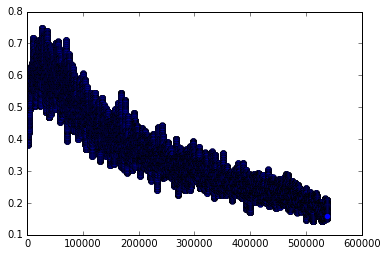

In [11]:
len(x_train)

856848